# Completeness at the genus, species, and "below species" ranks

Main sections:  
[Completeness across all bugphyzz](#bp)  
[Completeness of the aerophilicity dataset](#aer)  
[Completeness per attribute of the aerohpilicity dataset](#aer-attr)

Completeness of NCBI_ID annotations:

$$\text{Completeness (%)} = \frac{\text{N taxa in BugPhyzz}}{\text{N taxa in NCBI}} * 100$$

> Currently, completeness is based on genus, species, and taxa with ranks below
> species (e.g. strain, subspecies, no rank) because these are the possible
> ranks of the taxids in bugphyzz.

In [1]:
suppressMessages({
    library(bugphyzz)
    library(tidyverse)
    library(ggpubr)
})

# Completeness across all bugphyzz datasets

## Full NCBI taxonomy

The full NCBI taxonomy can be obtained from the taxdump files available at the
[NCBI's FTP site](https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/new_taxdump/).
A local copy of this information can be downloaded and imported into R.

> Since the taxonomy database is constantly being updated, the final numbers may vary a little.

In [2]:
## Checksums
expected_checksums <- as.character(read.table("./new_taxdump.tar.gz.md5")[1,1])
actual_checksums <- as.character(tools::md5sum("./new_taxdump.tar.gz"))
isTRUE(expected_checksums == actual_checksums)


[1] TRUE

The required information to create a taxonomy table is in the 'nodes.dmp' and 'rankedlineage.dmp' files. More information about these files at: https://ftp.ncbi.nlm.nih.gov/pub/taxonomy/new_taxdump/taxdump_readme.txt

In [3]:
taxonomy_table <- readRDS("./ncbi_taxonomy_table.rds")
glimpse(taxonomy_table)

Rows: 2,363,029
Columns: 11
$ superkingdom <chr> NA, NA, NA, "Archaea", "Archaea", "Archaea", "Archaea", "…
$ kingdom      <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ phylum       <chr> NA, NA, NA, NA, NA, "Candidatus Baldrarchaeota", "Candida…
$ class        <chr> NA, NA, NA, NA, NA, NA, "Candidatus Baldrarchaeia", "Cand…
$ order        <chr> NA, NA, NA, NA, NA, NA, NA, "Candidatus Baldrarchaeales",…
$ family       <chr> NA, NA, NA, NA, NA, NA, NA, NA, "Candidatus Baldrarchaeac…
$ genus        <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, "Candidatus Baldrarch…
$ species      <chr> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ NCBI_ID      <chr> "1", "131567", "2157", "1935183", "2798909", "2798916", "…
$ tax_name     <chr> "root", "cellular organisms", "Archaea", "Asgard group", …
$ rank         <chr> "no rank", "no rank", "superkingdom", "clade", "phylum", …


## Numbers in the NCBI database

Counts can be generated with the `countNcbiTaxonomyByRank` function:

In [4]:
countNcbiTaxonomyByRank <- function(tax_tbl, count_rank, grouping_rank) {

    valid_grouping_ranks <- c("superkingdom", "kingdom", "phylum", "class",
                              "order", "family", "genus", "species")
    valid_count_ranks <- c(valid_grouping_ranks, "below_species")

    if (!count_rank %in% valid_count_ranks)
        stop("Invalid rank value: ", count_rank, ". Valid values: ", paste0(valid_count_ranks, collapse = ", "), ".", call. = FALSE)

    if (!grouping_rank %in% valid_grouping_ranks)
        stop("Invalid grouping rank value: ", grouping_rank, ". Valid values: ", paste0(valid_grouping_ranks, collapse = ", "), ".", call. = FALSE)

    grouping_rank_index <- which(valid_grouping_ranks == grouping_rank)
    count_rank_index <- which(valid_count_ranks == count_rank)

    if (count_rank_index < grouping_rank_index)
        stop("Error in rank order. Attempting to count ", count_rank, " when grouping by ", grouping_rank, ".",
             " Probably you meant `count_rank = '", grouping_rank, "'` and `grouping_rank = '", count_rank, "'`.", call. = FALSE)

    if (count_rank_index == grouping_rank_index)
        stop("Count and grouping ranks are the same. Grouping rank must be higher than count rank.",
             " You cound try `count_rank = '", count_rank, "'` and `grouping_rank = '",
             valid_grouping_ranks[grouping_rank_index - 1], "'` instead.", call. = FALSE)

    grp_cols <- valid_grouping_ranks[1:grouping_rank_index]

    if (count_rank %in% valid_grouping_ranks) {
        count_table <- tax_tbl %>%
            dplyr::filter(rank == count_rank) %>%
            dplyr::select(tidyselect::all_of(c(grp_cols, "NCBI_ID"))) %>%
            dplyr::distinct() %>%
            dplyr::group_by_at(grp_cols) %>%
            dplyr::summarise(count = dplyr::n()) %>%
            suppressMessages() %>% 
            dplyr::ungroup()
        return(count_table)
    } else if (count_rank == "below_species") {
        count_table <- tax_tbl %>%
            dplyr::filter(!is.na(species)) %>%
            dplyr::select(tidyselect::all_of(c(grp_cols, "NCBI_ID"))) %>%
            dplyr::distinct() %>%
            dplyr::group_by_at(grp_cols) %>%
            dplyr::summarise(count = dplyr::n()) %>%
            suppressMessages() %>% 
            dplyr::ungroup()
        return(count_table)
    }

}

Generate group counts for the full NCBI taxonomy table:

In [5]:
# create ncbi_taxonomy_counts
my_ranks = c("genus", "species", "below_species")
my_grp_ranks = c("superkingdom", "kingdom", "phylum")
vct_len <- length(my_ranks) * length(my_grp_ranks)
ncbi_taxonomy_counts <- vector("list", vct_len)
counter <- 1
for (i in seq_along(my_ranks)) {
    for (j in seq_along(my_grp_ranks)) {
        ncbi_taxonomy_counts[[counter]] <- countNcbiTaxonomyByRank(taxonomy_table, my_ranks[i], my_grp_ranks[j])
        names(ncbi_taxonomy_counts)[counter] <- paste0(my_ranks[i], "_", my_grp_ranks[j])
        counter <- counter + 1
    }
}
ncbi_taxonomy_counts <- map(ncbi_taxonomy_counts, ~ rename(.x, ncbi_count = count)) 
str(ncbi_taxonomy_counts, max.level = 1)

List of 9
 $ genus_superkingdom        : tibble [5 × 2] (S3: tbl_df/tbl/data.frame)
 $ genus_kingdom             : tibble [18 × 3] (S3: tbl_df/tbl/data.frame)
 $ genus_phylum              : tibble [185 × 4] (S3: tbl_df/tbl/data.frame)
 $ species_superkingdom      : tibble [5 × 2] (S3: tbl_df/tbl/data.frame)
 $ species_kingdom           : tibble [18 × 3] (S3: tbl_df/tbl/data.frame)
 $ species_phylum            : tibble [299 × 4] (S3: tbl_df/tbl/data.frame)
 $ below_species_superkingdom: tibble [5 × 2] (S3: tbl_df/tbl/data.frame)
 $ below_species_kingdom     : tibble [18 × 3] (S3: tbl_df/tbl/data.frame)
 $ below_species_phylum      : tibble [127 × 4] (S3: tbl_df/tbl/data.frame)


## Numbers in bugphyzz

Counts can be generated with the `countNcbiTaxonomyByRank`:

In [6]:
## Get the full taxonomy of all of the taxids in bugphyzz
## in the same format as the NCBI taxonomy table
bp_taxids <- bugphyzz:::.taxonomyTable()$NCBI_ID # all taxids
bp_taxonomy_table <- taxonomy_table %>% 
  filter(NCBI_ID %in% bp_taxids)

## Counts in bugphyzz
my_ranks = c("genus", "species", "below_species")
my_grp_ranks = c("superkingdom", "kingdom", "phylum")
vct_len <- length(my_ranks) * length(my_grp_ranks)
bp_taxonomy_counts <- vector("list", vct_len)
counter <- 1
for (i in seq_along(my_ranks)) {
    for (j in seq_along(my_ranks)) {
        bp_taxonomy_counts[[counter]] <- countNcbiTaxonomyByRank(bp_taxonomy_table, my_ranks[i], my_grp_ranks[j])
        names(bp_taxonomy_counts)[counter] <- paste0(my_ranks[i], "_", my_grp_ranks[j])
        counter <- counter + 1
    }
}
bp_taxonomy_counts <- map(bp_taxonomy_counts, ~ rename(.x, bp_count = count)) 
str(bp_taxonomy_counts, max.level = 1)

List of 9
 $ genus_superkingdom        : tibble [3 × 2] (S3: tbl_df/tbl/data.frame)
 $ genus_kingdom             : tibble [3 × 3] (S3: tbl_df/tbl/data.frame)
 $ genus_phylum              : tibble [41 × 4] (S3: tbl_df/tbl/data.frame)
 $ species_superkingdom      : tibble [3 × 2] (S3: tbl_df/tbl/data.frame)
 $ species_kingdom           : tibble [5 × 3] (S3: tbl_df/tbl/data.frame)
 $ species_phylum            : tibble [50 × 4] (S3: tbl_df/tbl/data.frame)
 $ below_species_superkingdom: tibble [3 × 2] (S3: tbl_df/tbl/data.frame)
 $ below_species_kingdom     : tibble [3 × 3] (S3: tbl_df/tbl/data.frame)
 $ below_species_phylum      : tibble [34 × 4] (S3: tbl_df/tbl/data.frame)


## Calculate completeness across all bugphyzz

In [7]:
completeness_bp <- map2(bp_taxonomy_counts, ncbi_taxonomy_counts, ~ {
    full_join(.x, .y) %>% 
      suppressMessages() %>% 
      mutate(completeness = round(bp_count / ncbi_count * 100, 2)) %>% 
      filter(!is.na(completeness))
})

## Plot completeness <a name="bp"></a>

**Plot completeness grouped by superkingdom**

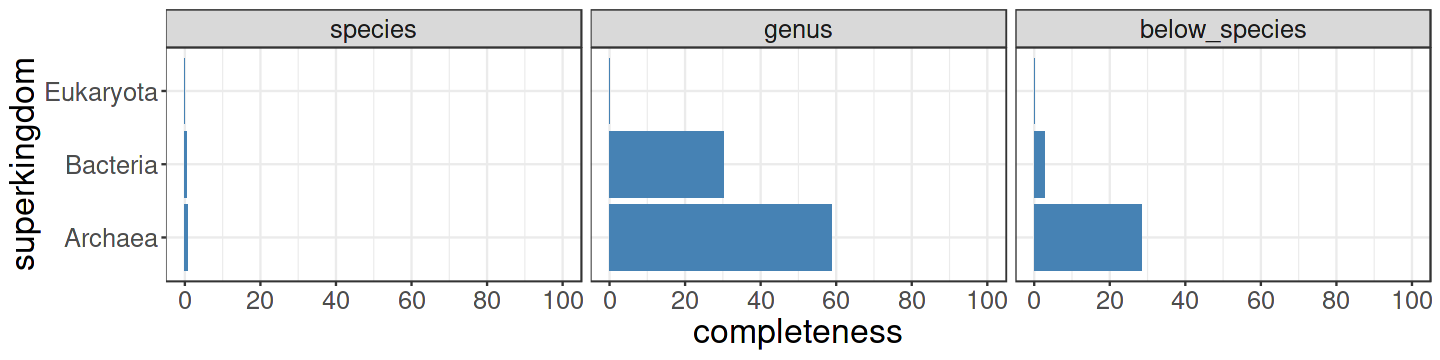

In [8]:
options(repr.plot.width = 12, repr.plot.height = 3)
completeness_bp[str_detect(names(completeness_bp), "superkingdom")] %>% 
    bind_rows(.id = "rank") %>% 
    mutate(rank = str_remove(rank, paste0("_(", paste0(my_grp_ranks, collapse = "|"), ")")),
           rank = fct_relevel(rank, "species", "genus")) %>% 
    ggplot(aes(superkingdom, completeness)) +
    geom_col(fill = "steelblue") +
    scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, 20)) +
    facet_wrap(~rank, ncol = 3, strip.position = "top") +
    coord_flip() +
    theme_bw() +
    theme(
        axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        axis.title.y = element_text(margin = unit(c(0, 5, 0, 0), "mm")),
        strip.text = element_text(size = 15)
    )

**Plot completeness grouped by kingdom**

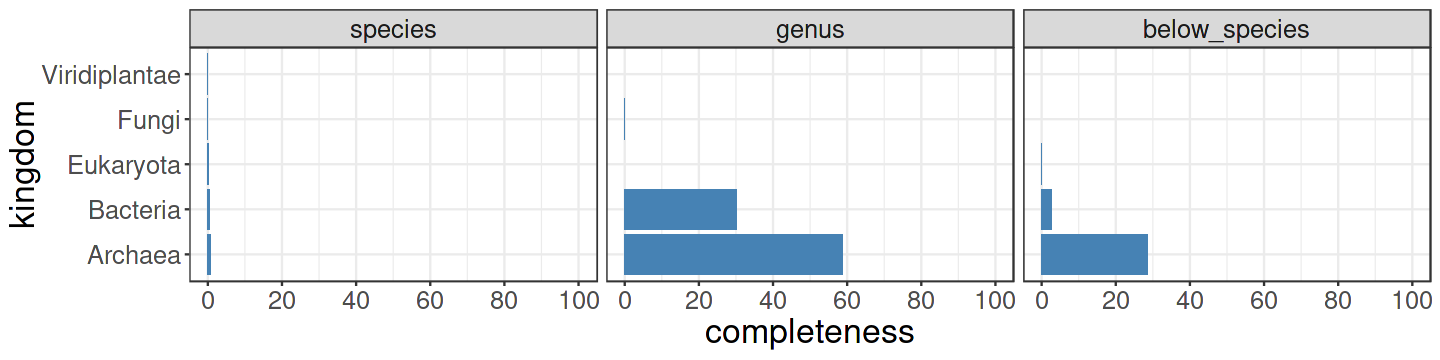

In [9]:
options(repr.plot.width = 12, repr.plot.height = 3)
completeness_bp[str_detect(names(completeness_bp), "_kingdom$")] %>% 
    bind_rows(.id = "rank") %>% 
    mutate(rank = str_remove(rank, paste0("_(", paste0(my_grp_ranks, collapse = "|"), ")")),
           rank = fct_relevel(rank, "species", "genus"),
           kingdom = ifelse(is.na(kingdom), superkingdom, kingdom)) %>% 
    ggplot(aes(kingdom, completeness)) +
    geom_col(fill = "steelblue") +
    scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, 20)) +
    facet_wrap(~rank, ncol = 3, strip.position = "top") +
    coord_flip() +
    theme_bw() +
    theme(
        axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        axis.title.y = element_text(margin = unit(c(0, 5, 0, 0), "mm")),
        strip.text = element_text(size = 15)
    )

**Plot completeness grouped by phylum**

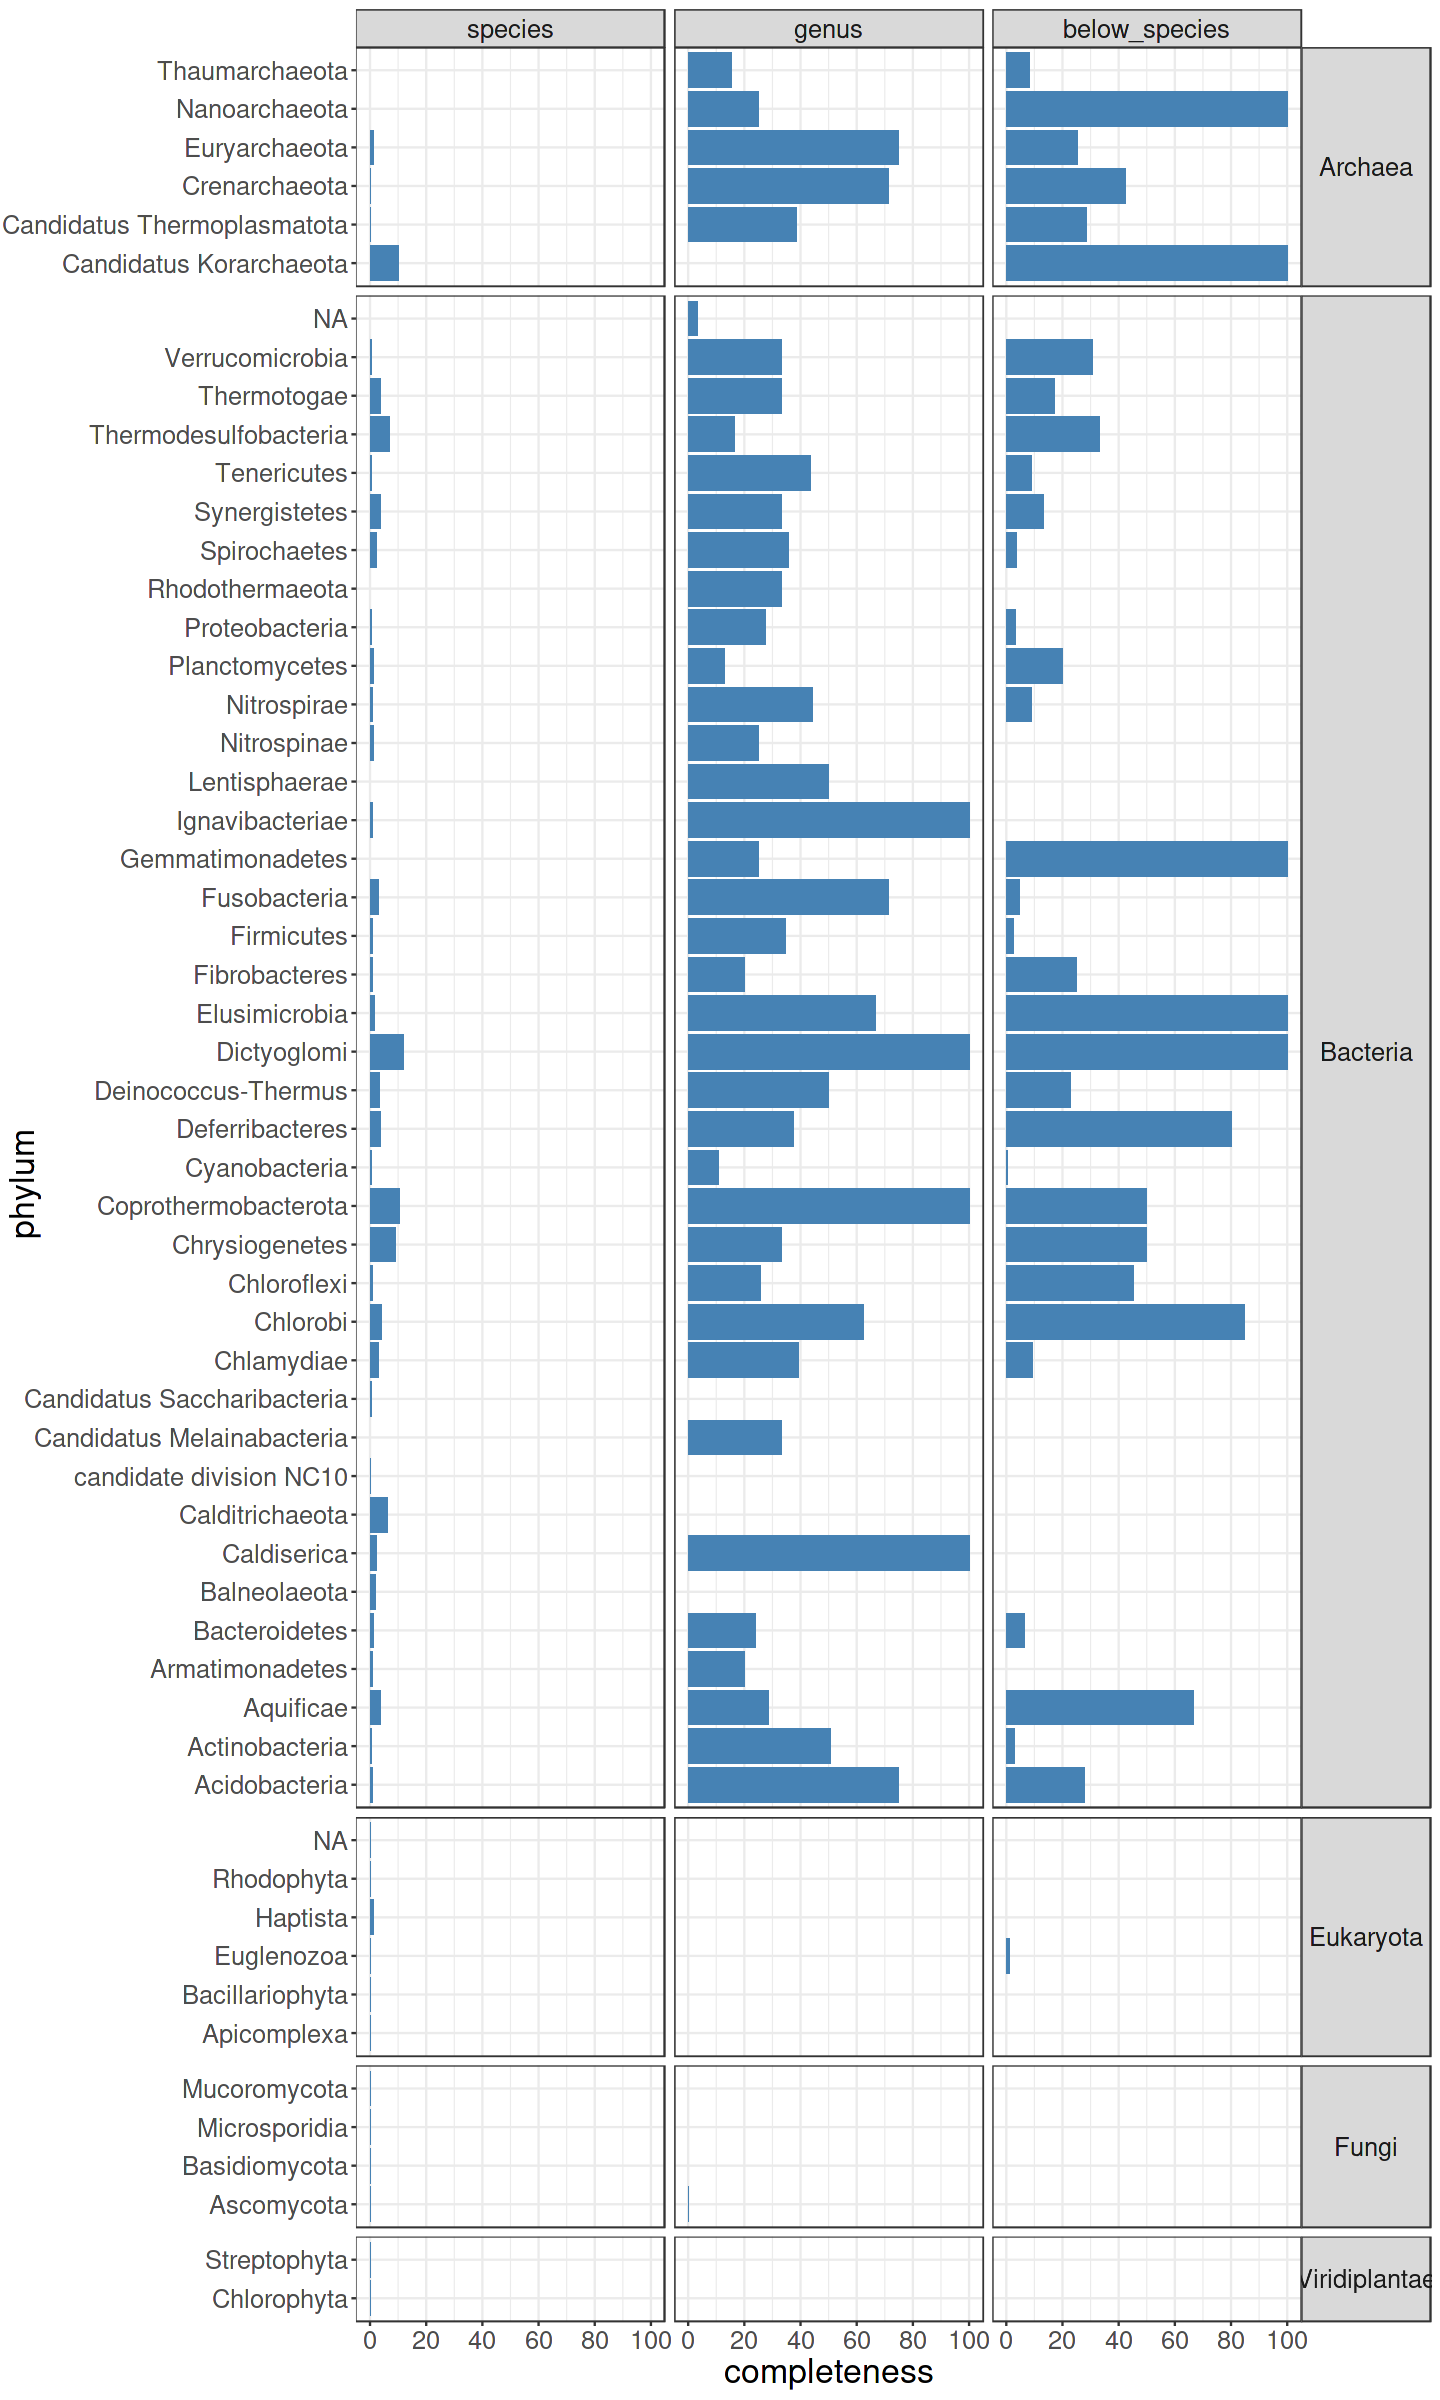

In [10]:
options(repr.plot.width = 12, repr.plot.height = 20)
completeness_bp[str_detect(names(completeness_bp), "_phylum$")] %>% 
    bind_rows(.id = "rank") %>% 
    mutate(rank = str_remove(rank, paste0("_(", paste0(my_grp_ranks, collapse = "|"), ")")),
           rank = fct_relevel(rank, "species", "genus"),
           kingdom = ifelse(is.na(kingdom), superkingdom, kingdom)) %>% 
    ggplot(aes(phylum, completeness)) +
    geom_col(fill = "steelblue") +
    scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, 20)) +
    facet_grid(kingdom ~ rank, scales = "free_y", space = "free") +
    coord_flip() +
    theme_bw() +
    theme(
        strip.text.y = element_text(angle = 360),
        axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        axis.title.y = element_text(margin = unit(c(0, 5, 0, 0), "mm")),
        strip.text = element_text(size = 15)
    )

# Some functions

A function to count taxa:

In [11]:
count_taxa <- function(x) {
  my_ranks <- c("genus", "species", "below_species")
  my_grp_ranks <- c("superkingdom", "kingdom", "phylum")
  
  vct_len <- length(my_ranks) * length(my_grp_ranks)
  output <- vector("list", vct_len)
  counter <- 1
  for (i in seq_along(my_ranks)) {
    for (j in seq_along(my_grp_ranks)) {
      output[[counter]] <- countNcbiTaxonomyByRank(x, my_ranks[i], my_grp_ranks[j])
      names(output)[counter] <- paste0(my_ranks[i], "_", my_grp_ranks[j])
      counter <- counter +1
    }
  }
  output <- map(output, ~ rename(.x, x_count = count))
  output
}

A function for calculating completeness:

In [12]:
calculate_completeness <- function(x, y) {
    map2(x, y, ~ {
        full_join(.x, .y) %>% 
            suppressMessages() %>% 
            mutate(completeness = round(x_count / ncbi_count * 100, 2)) %>% 
            filter(!is.na(completeness))
    } )
}

Some functions for plotting:

In [13]:
## superkingdom
plot_sk <- function(x, fill_col = "steelblue") {
    my_grp_ranks = c("superkingdom", "kingdom", "phylum")
    x[str_detect(names(x), "superkingdom")] %>% 
    bind_rows(.id = "rank") %>% 
    mutate(rank = str_remove(rank, paste0("_(", paste0(my_grp_ranks, collapse = "|"), ")")),
           rank = fct_relevel(rank, "species", "genus")) %>% 
    ggplot(aes(superkingdom, completeness)) +
    geom_col(fill = fill_col) +
    scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, 20)) +
    facet_wrap(~rank, ncol = 3, strip.position = "top") +
    coord_flip() +
    theme_bw() +
        theme(
        strip.text.y = element_text(angle = 360),
        axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        axis.title.y = element_text(margin = unit(c(0, 5, 0, 0), "mm")),
        strip.text = element_text(size = 15)
    )
}

## kingdom
plot_kg <- function(x, fill_col = "steelblue") {
    my_grp_ranks = c("superkingdom", "kingdom", "phylum")
    x[str_detect(names(x), "_kingdom$")] %>% 
    bind_rows(.id = "rank") %>% 
    mutate(rank = str_remove(rank, paste0("_(", paste0(my_grp_ranks, collapse = "|"), ")")),
           rank = fct_relevel(rank, "species", "genus"),
           kingdom = ifelse(is.na(kingdom), superkingdom, kingdom)) %>% 
    ggplot(aes(kingdom, completeness)) +
    geom_col(fill = fill_col) +
    scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, 20)) +
    facet_wrap(~rank, ncol = 3, strip.position = "top") +
    coord_flip() +
    theme_bw() +
    theme(
        strip.text.y = element_text(angle = 360),
        axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        axis.title.y = element_text(margin = unit(c(0, 5, 0, 0), "mm")),
        strip.text = element_text(size = 15)
    )
}

## phylum
plot_ph <- function(x, fill_col = "steelblue") {
    my_grp_ranks = c("superkingdom", "kingdom", "phylum")
    x[str_detect(names(x), "_phylum$")] %>% 
    bind_rows(.id = "rank") %>% 
    mutate(rank = str_remove(rank, paste0("_(", paste0(my_grp_ranks, collapse = "|"), ")")),
           rank = fct_relevel(rank, "species", "genus"),
           kingdom = ifelse(is.na(kingdom), superkingdom, kingdom)) %>% 
    ggplot(aes(phylum, completeness)) +
    geom_col(fill = fill_col) +
    scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, 20)) +
    facet_grid(kingdom ~ rank, scales = "free_y", space = "free") +
    coord_flip() +
    theme_bw() +
    theme(
        strip.text.y = element_text(angle = 360),
        axis.text = element_text(size = 15),
        axis.title = element_text(size = 20),
        strip.text = element_text(size = 15)
    )
}

# Aerophilicity (categorical)

## Complete dataset <a name="aer"></a>

Calculate completeness

In [14]:
## 1. Get taxonomy table for the aerophilicity dataset:
aer <- physiologies("aerophilicity")[[1]] %>% 
    as_tibble()

aer_taxids <- aer$NCBI_ID %>% 
    as.integer() %>% 
    as.character() %>% 
    unique() %>% 
    .[!is.na(.)]

aer_taxonomy <- taxonomy_table %>% 
    filter(NCBI_ID %in% aer_taxids)

## 2. Get counts for the aerophilicity dataset:
aer_taxonomy_counts <- count_taxa(aer_taxonomy)

## 3. Calculate completeness for the aerophilicity dataset:
aer_completeness <- calculate_completeness(aer_taxonomy_counts, ncbi_taxonomy_counts)

Finished aerophilicity



Plotting:

**Superkingdom**

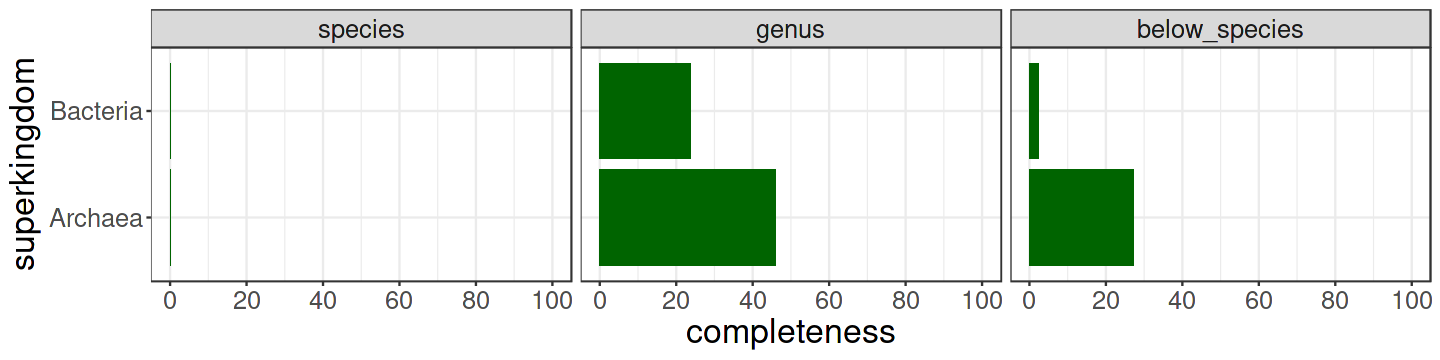

In [15]:
options(repr.plot.width = 12, repr.plot.height = 3)
plot_sk(aer_completeness, fill_col = "darkgreen")

**Kingdom**

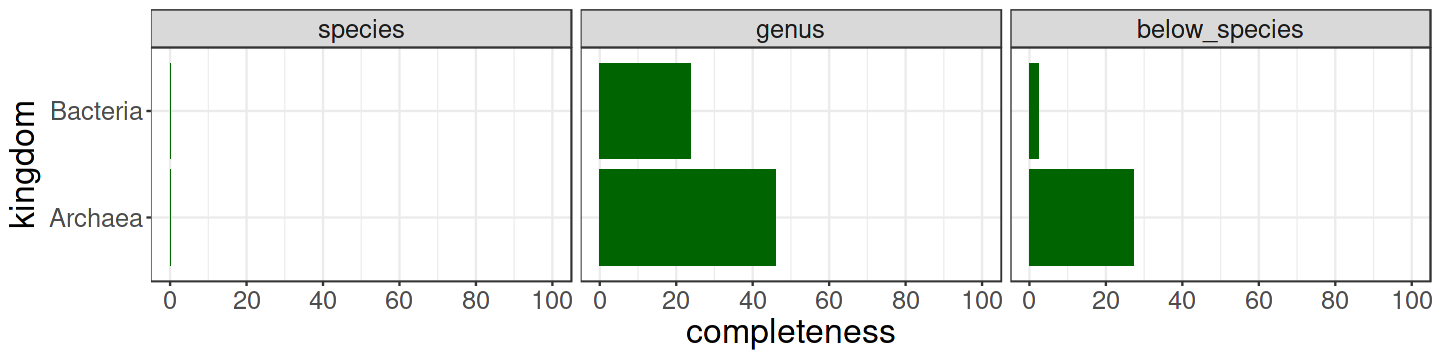

In [16]:
options(repr.plot.width = 12, repr.plot.height = 3)
plot_kg(aer_completeness, fill_col = "darkgreen")

**Phylum**

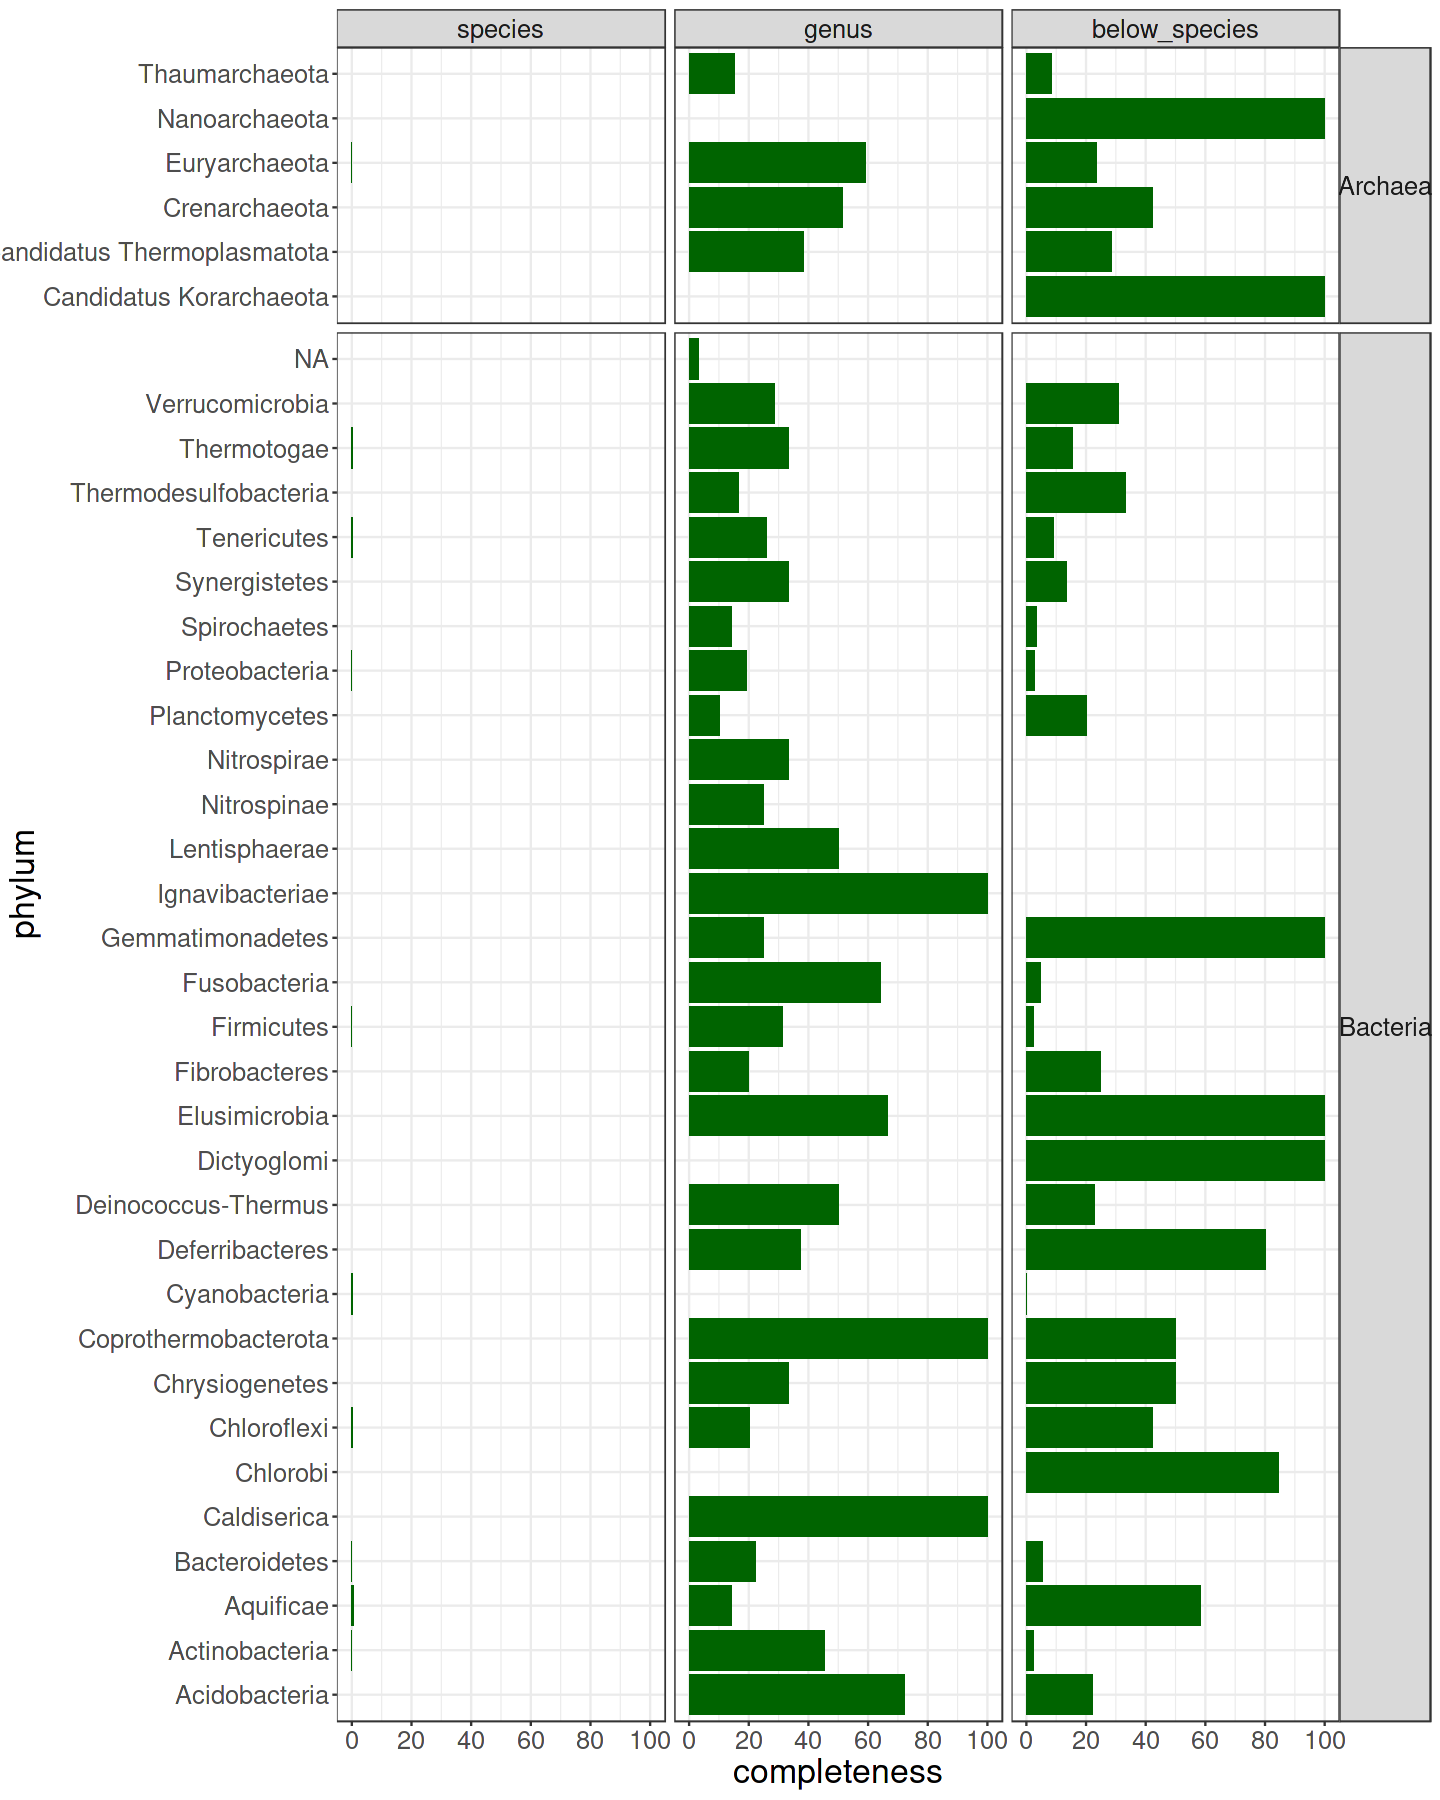

In [17]:
options(repr.plot.width = 12, repr.plot.height = 15)
plot_ph(aer_completeness, fill_col = "darkgreen")

## Completeness per attribute <a name="aer-attr"></a>

In [18]:
## 1. Split aerophilicity dataset by attributes
aer_attributes <- aer %>% 
    mutate(NCBI_ID = as.character(as.integer(NCBI_ID))) %>% 
    filter(!is.na(NCBI_ID), !is.na(Attribute_value), Attribute_value == TRUE) %>% 
    select(Attribute, NCBI_ID) %>% 
    distinct() %>% 
    split(.$Attribute) # returns list of tables with attributes

## 2. Create a taxonomy table for each dataset
aer_attributes_taxonomy <- aer_attributes %>% 
    map(~ filter(taxonomy_table, NCBI_ID %in% .x$NCBI_ID))

## 3. Count taxa per attribute
aer_attributes_taxonomy_counts <- aer_attributes_taxonomy %>% 
    map(~ count_taxa(.x))

## 4. Calculate completeness per attribute
aer_attributes_completeness <- aer_attributes_taxonomy_counts %>% 
    map(~ calculate_completeness(x = ., y = ncbi_taxonomy_counts))

### Aerobic

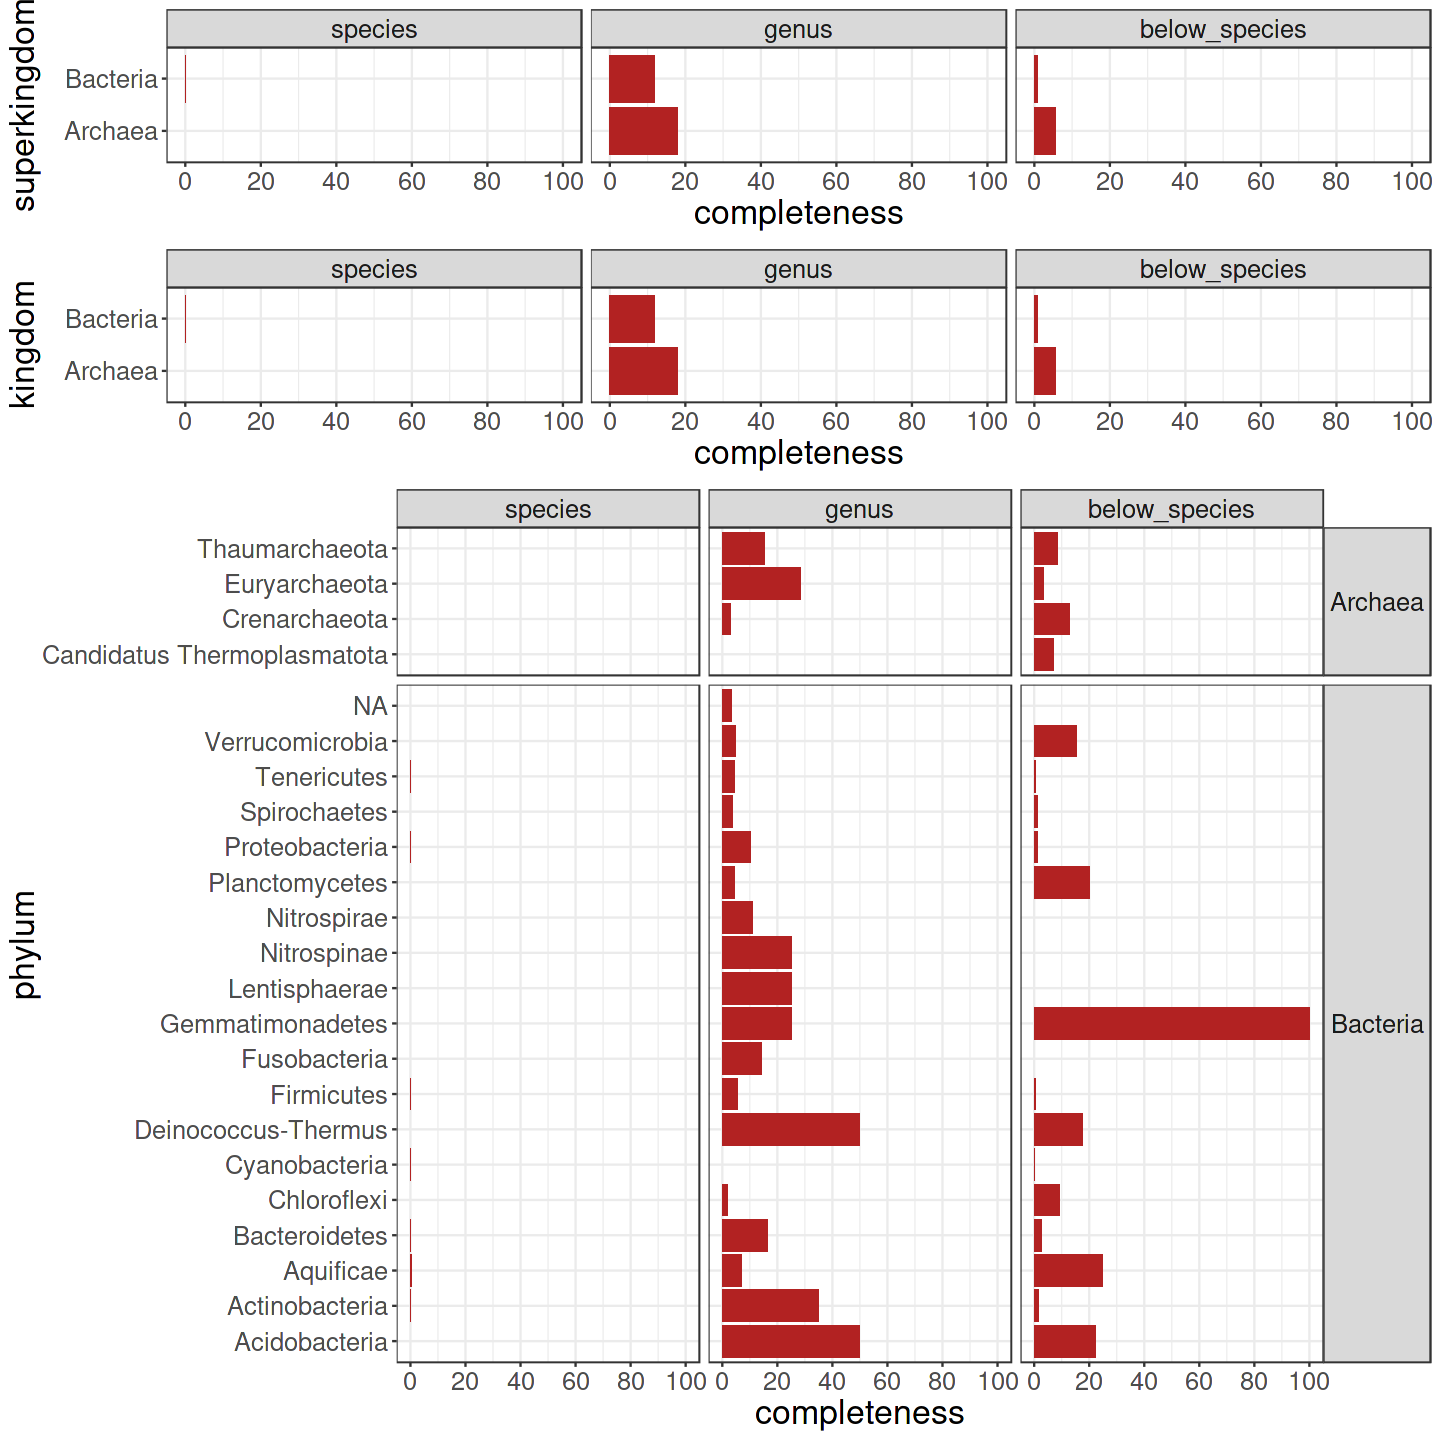

In [19]:
options(repr.plot.width = 12, repr.plot.height = 12)
p1 <- plot_sk(aer_attributes_completeness$aerobic, fill_col = "firebrick")
p2 <- plot_kg(aer_attributes_completeness$aerobic, fill_col = "firebrick")
p3 <- plot_ph(aer_attributes_completeness$aerobic, fill_col = "firebrick")

ggarrange(p1, p2, p3, ncol = 1, heights = c(1, 1, 4))

### Anerobic

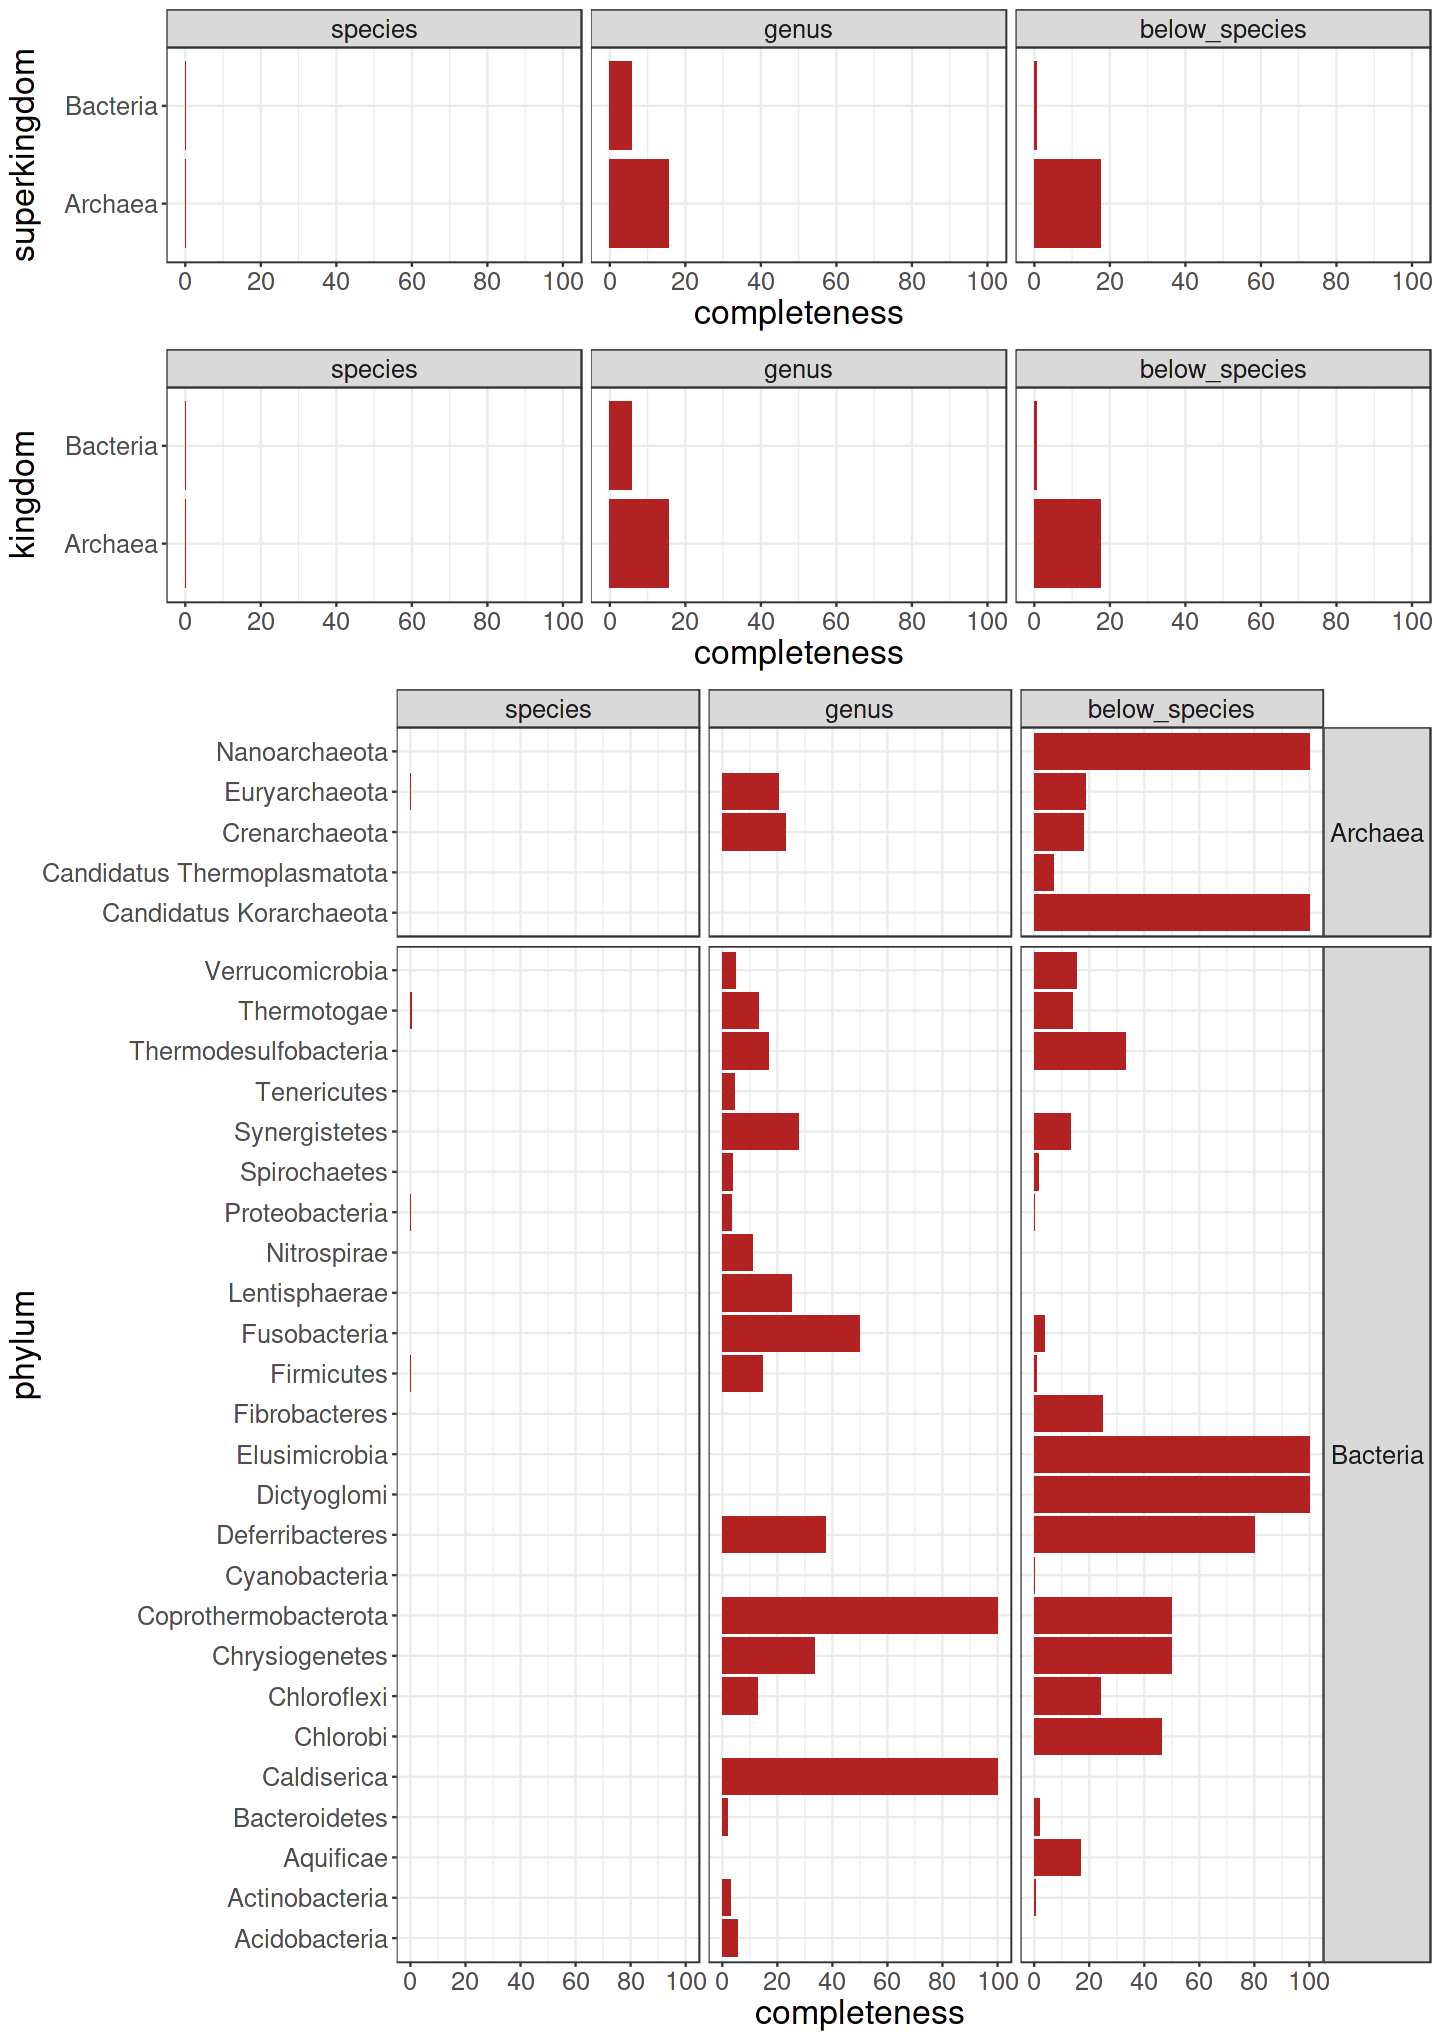

In [20]:
options(repr.plot.width = 12, repr.plot.height = 17)
p1 <- plot_sk(aer_attributes_completeness$anaerobic, fill_col = "firebrick")
p2 <- plot_kg(aer_attributes_completeness$anaerobic, fill_col = "firebrick")
p3 <- plot_ph(aer_attributes_completeness$anaerobic, fill_col = "firebrick")

ggarrange(p1, p2, p3, ncol = 1, heights = c(1, 1, 4))

### Facultatively anaerobic

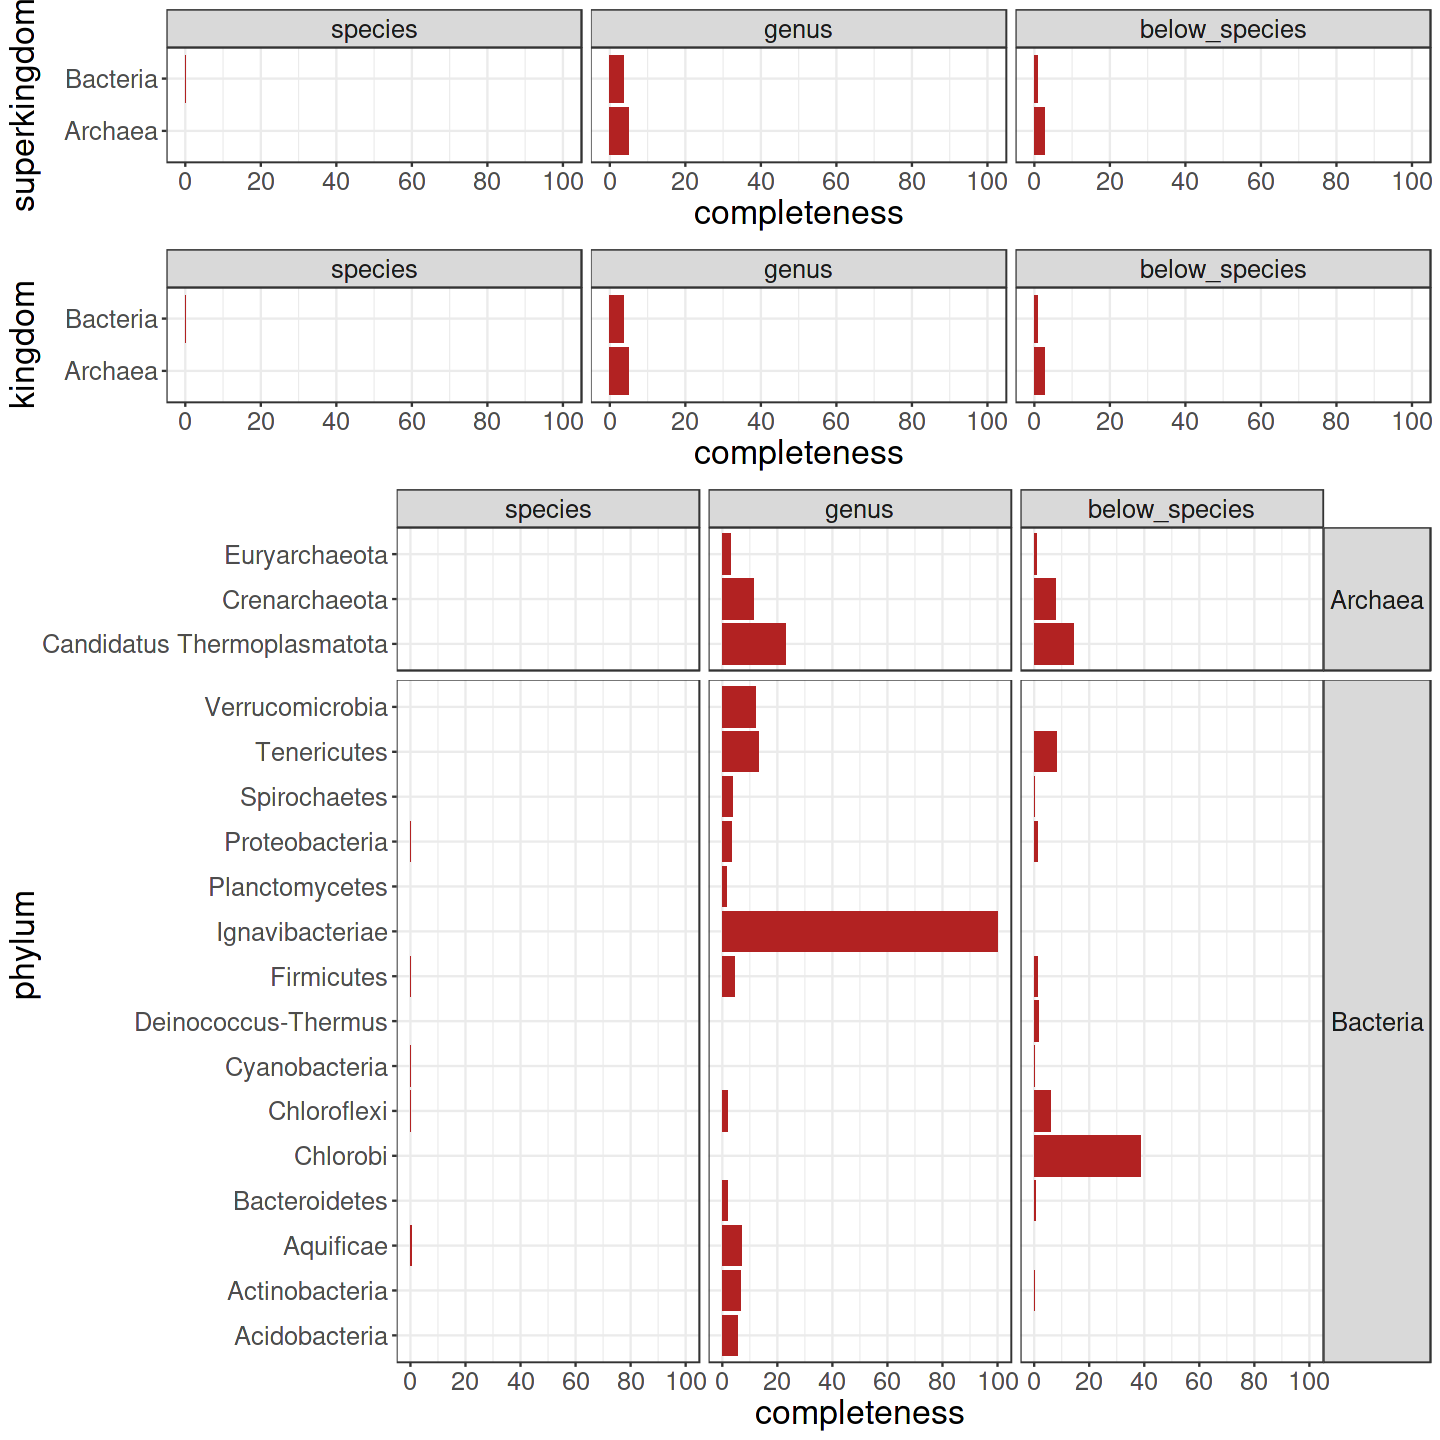

In [21]:
options(repr.plot.width = 12, repr.plot.height = 12)
p1 <- plot_sk(aer_attributes_completeness$`facultatively anaerobic`, fill_col = "firebrick")
p2 <- plot_kg(aer_attributes_completeness$`facultatively anaerobic`, fill_col = "firebrick")
p3 <- plot_ph(aer_attributes_completeness$`facultatively anaerobic`, fill_col = "firebrick")

ggarrange(p1, p2, p3, ncol = 1, heights = c(1, 1, 4))